In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
import random

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.sans-serif'] = ['Arial']
rcParams['font.family'] = 'sans-serif'


In [ ]:
data = pd.read_csv('drive/My Drive/Colab Notebooks/Classification/new_drop+interpolate.csv')

data['timestamp'] = pd.to_datetime(data['datetime_utc'])
data.set_index('timestamp', inplace=True)
data = data.reset_index()
import pandas as pd

data['datetime'] = pd.to_datetime(data['timestamp'])

data['month'] = data['datetime'].dt.month

def get_season(month):
    if month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3
    else:
        return 4

data['season'] = data['month'].apply(get_season)

In [ ]:
from sklearn.ensemble import StackingClassifier

stacked_model = StackingClassifier(
    estimators=[
        ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42,max_depth = 5)),
        ('adaboost', AdaBoostClassifier(DecisionTreeClassifier(max_depth = 5), n_estimators=100, random_state=42))
    ],
    final_estimator=AdaBoostClassifier(DecisionTreeClassifier(max_depth = 5), n_estimators=100, random_state=42)
)

from keras.models import Sequential
from keras.layers import Dense,Dropout
def create_mlp_model(input_dim,random_seed):
    tf.random.set_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from tensorflow.keras.optimizers import Adam

def create_model(input_shape,random_seed):
    tf.random.set_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape= input_shape),
        MaxPooling1D(pool_size=1),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
class ResNetTabular:
    def __init__(self, num_features, num_classes, epochs, batch_size, learning_rate):
        self.num_features = num_features
        self.num_classes = num_classes
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = models.resnet50(pretrained=True)
        self.model.conv1 = nn.Conv2d(num_features, 64, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), bias=False)

        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

        self.model = self.model.to(self.device)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

    def train(self, train_x, train_y):
        train_x = train_x.reshape(-1, self.num_features, 1, 1)

        dataset = TensorDataset(torch.tensor(train_x, dtype=torch.float32), torch.tensor(train_y, dtype=torch.long))
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        self.model.train()

        for epoch in range(self.epochs):
            running_loss = 0.0
            for inputs, labels in dataloader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                self.optimizer.zero_grad()

                # Forward + backward + optimize
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            print(f'Epoch {epoch + 1}/{self.epochs} - Loss: {running_loss / len(dataloader)}')

    def predict(self, test_x):
        test_x = test_x.reshape(-1, self.num_features, 1, 1)
        test_x = torch.tensor(test_x, dtype=torch.float32)
        test_x = test_x.to(self.device)

        self.model.eval()

        predictions = []
        with torch.no_grad():
            outputs = self.model(test_x)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())

        return predictions
    def predict_proba(self, test_x):
        test_x = test_x.reshape(-1, self.num_features, 1, 1)
        test_x = torch.tensor(test_x, dtype=torch.float32)
        test_x = test_x.to(self.device)

        self.model.eval()

        probabilities = []
        with torch.no_grad():
            outputs = self.model(test_x)
            probs = F.softmax(outputs, dim=1)
            probabilities.extend(probs.cpu().numpy())

        return probabilities


In [ ]:
from sklearn.metrics import pairwise_distances
import random

def maximin_sampling_whale(data_whale_detected, num_samples, random_state=None):
    if random_state is not None:
        random.seed(random_state)

    initial_point = data_whale_detected.sample(1, random_state=random_state)  # initial point
    sampled_points = initial_point.copy()
    remaining_points = data_whale_detected.drop(initial_point.index)  # remaining point

    while len(sampled_points) < num_samples:
        distances = pairwise_distances(remaining_points[['lon', 'lat']], sampled_points[['lon', 'lat']])
        min_distances = np.min(distances, axis=1)

        # chose from upper 90 percent
        farthest_points = remaining_points[min_distances >= np.percentile(min_distances, 90)]
        if len(farthest_points) > 0:
            # random select
            next_point = farthest_points.sample(1, random_state=random_state)
        else:
            # if don't have, choose furthest
            next_point_index = np.argmax(min_distances)
            next_point = remaining_points.iloc[[next_point_index]]

        sampled_points = pd.concat([sampled_points, next_point])
        remaining_points = remaining_points.drop(next_point.index)

    return sampled_points



def stratified_max_min_sampling(data, stratify_col, test_ratio,random_state):
    test_samples = []
    unique_values = data[stratify_col].unique()

    for value in unique_values:
        subset = data[data[stratify_col] == value]
        n_samples = int(len(subset) * test_ratio)
        subset_test = maximin_sampling_whale(subset, n_samples,random_state)
        test_samples.append(subset_test)

    return pd.concat(test_samples)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
models1 = [
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('ada', AdaBoostClassifier(n_estimators=100)),
    ('svm', Pipeline([('scaler', MinMaxScaler()), ('svc', SVC(probability=True))])),
    ('knn', Pipeline([('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())]))
]
stacked_model1 = StackingClassifier(estimators=models1,final_estimator= LogisticRegression()
)

models2 = [
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('ada', AdaBoostClassifier(n_estimators=100)),
    ('knn', Pipeline([('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())]))
]
SoftVote2 = VotingClassifier(estimators=models2, voting='soft')

In [ ]:
## Compare with the same train/test dataset
import warnings
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import pairwise_distances
from joblib import dump
import xgboost as xgb
import torch
from google.colab import files
warnings.filterwarnings('ignore', category=FutureWarning)
features_sets = {
    'glider': ['depth', 'salinity', 'temperature', 'oxygen_concentration','season'],
    'satellite': ['chl_oc3', 'sst', 'M_WK', 'M_WK_G','season'],
    'both': ['depth', 'salinity', 'temperature', 'oxygen_concentration', 'chl_oc3', 'sst', 'M_WK', 'M_WK_G','season']
}
##定义模型
models_dict = {
    "Logistic Regression": None,
    "SVM": None,
    "KNN": None,
    "Random Forest": None,
    "AdaBoost": None,
    "MLP": None,
    "CNN": None,
    #"Ensemble": None,
    "XGBoost": None,
    "ResNet": None
    #"Ensemble1": None,
    #"Ensemble2": None
}
iterations = 10
test_sets = {}
train_sets = {}
# store results
predictions_dict = {}
all_test_sets = all_test_sets = pd.DataFrame()
results = {feature_set_name: {model_name: {'cumulative_confusion_matrix': np.zeros((2, 2)),
                                           'accuracies': [],
                                           'f1_scores': [],
                                           'tprs': [],
                                           'tnrs': [],
                                           'roc_aucs': [],
                                           'tprs_interpolated': [],
                                           'probs_0': [],
                                           'probs_1': []}
                             for model_name in models_dict}
            for feature_set_name in features_sets}
mean_fpr = np.linspace(0, 1, 100)
for i in range(iterations):

    test_set = stratified_max_min_sampling(data, 'Whale_Status_Code', 0.2,i)
    test_sets[i] = test_set  # store every iteration test_set
    test_set['iteration'] = i
    all_test_sets = pd.concat([all_test_sets, test_set]) ##all test samples
    train_set = data.drop(test_set.index)
    train_sets[i] = train_set
    print(f"Iteration {i}: Test set indices: {test_set.index.tolist()}")
    for feature_set_name, feature_set in features_sets.items():
        print(f"Feature Set: {feature_set_name}")
        X_train = train_set[feature_set]
        y_train = train_set['Whale_Status_Code']
        X_test = test_set[feature_set]
        y_test = test_set['Whale_Status_Code']
        smote = SMOTE(sampling_strategy=0.45, random_state=42)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
        # recreate model in the next iteration
        models_dict['Logistic Regression'] = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)
        models_dict['SVM'] = SVC(kernel='rbf', C=5, probability=True, random_state=42)
        models_dict['KNN'] = KNeighborsClassifier(n_neighbors=5)
        models_dict['Random Forest'] = RandomForestClassifier(n_estimators=100, random_state=42,max_depth = 5)
        models_dict['AdaBoost'] = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 5), n_estimators=100, random_state=42)
        #models_dict['Ensemble1'] = stacked_model1
        #models_dict['Ensemble2'] = SoftVote2

        ## special deal
        input_dim = X_train.shape[1]
        models_dict['MLP'] = create_mlp_model(input_dim,random_seed = 42)
        models_dict['XGBoost'] = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
        models_dict['ResNet'] = ResNetTabular(input_dim,2,5,50,0.001)
        # special deal
        input_shape = (X_train_smote.shape[1], 1)
        models_dict['CNN'] = create_model(input_shape,random_seed = 42)
        # different models with different data processing ways

        for model_name, model in models_dict.items():
            if model_name in ['SVM', 'KNN', 'Logistic Regression']:
                scaler = MinMaxScaler()
                X_train_scale = scaler.fit_transform(X_train_smote)
                X_test_scale = scaler.transform(X_test)
                model.fit(X_train_scale,y_train_smote)
                filename = f"drive/My Drive/Colab Notebooks/Classification/model1/{model_name}_{feature_set_name}_{i}_model.joblib"
                dump(model, filename)
                y_pred_probs = model.predict_proba(X_test_scale)[:,1]
                y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]

            if model_name == 'MLP':
                scaler = MinMaxScaler()
                X_train_scale = scaler.fit_transform(X_train_smote)
                X_test_scale = scaler.transform(X_test)
                model.fit(X_train_scale, y_train_smote, epochs=50, batch_size=100)
                filename = f"drive/My Drive/Colab Notebooks/Classification/model1/{model_name}_{feature_set_name}_{i}_model.joblib"
                dump(model, filename)
                y_pred_probs = model.predict(X_test_scale)[:,0]
                y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]

            if model_name in ['Random Forest', 'AdaBoost','XGBoost']: #,'Ensemble1','Ensemble2']:
                model.fit(X_train_smote, y_train_smote)
                filename = f"drive/My Drive/Colab Notebooks/Classification/model1/{model_name}_{feature_set_name}_{i}_model.joblib"
                dump(model, filename)
                y_pred_probs = model.predict_proba(X_test)[:, 1]
                y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]

            if model_name == 'CNN':
                scaler = MinMaxScaler()
                X_train_scaled = scaler.fit_transform(X_train_smote)
                X_test_scaled = scaler.transform(X_test)

                X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
                X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
                model.fit(X_train_reshaped, y_train_smote, epochs=50, batch_size=100, verbose=0)
                filename = f"drive/My Drive/Colab Notebooks/Classification/model1/{model_name}_{feature_set_name}_{i}_model.joblib"
                dump(model, filename)
                y_pred_probs = model.predict(X_test_reshaped)[:, 0]
                y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]



            if model_name == "ResNet":
                # TabNet requires a slightly different data handling
                scaler = MinMaxScaler()
                X_train_scaled = scaler.fit_transform(X_train_smote)
                X_test_scaled = scaler.transform(X_test)
                model.train(X_train_scaled,y_train_smote)
                filename = f"drive/My Drive/Colab Notebooks/Classification/model1/{model_name}_{feature_set_name}_{i}_model.joblib"
                dump(model, filename)
                y_pred_probs = np.array(model.predict_proba(X_test_scaled))[:,1]
                y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]


            key = (i, feature_set_name, model_name)
            predictions_dict[key] = {'indices': test_set.index, 'predictions': y_pred}
            cm = confusion_matrix(y_test, y_pred)
            results[feature_set_name][model_name]['cumulative_confusion_matrix'] += cm
            results[feature_set_name][model_name]['accuracies'].append(accuracy_score(y_test, y_pred))
            results[feature_set_name][model_name]['f1_scores'].append(f1_score(y_test, y_pred))
            results[feature_set_name][model_name]['tprs'].append(cm[1, 1] / (cm[1, 1] + cm[1, 0]))
            results[feature_set_name][model_name]['tnrs'].append(cm[0, 0] / (cm[0, 0] + cm[0, 1]))
            results[feature_set_name][model_name]['probs_0'].extend(y_pred_probs[y_test == 0])
            results[feature_set_name][model_name]['probs_1'].extend(y_pred_probs[y_test == 1])


            fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
            results[feature_set_name][model_name]['roc_aucs'].append(auc(fpr, tpr))
            tpr_interp = np.interp(mean_fpr, fpr, tpr)
            tpr_interp[0] = 0.0
            results[feature_set_name][model_name]['tprs_interpolated'].append(tpr_interp)

# for feature_set_name, feature_set in features_sets.items():
#     for model_name, model in models_dict.items():
#         result = results[feature_set_name][model_name]

#         #
#         print(f"Feature Set: {feature_set_name}, Model: {model_name}")
#         print("Cumulative confusion matrix:")
#         print(result['cumulative_confusion_matrix'])
#         mean_accuracy = np.mean(result['accuracies'])
#         mean_f1_score = np.mean(result['f1_scores'])
#         mean_tpr = np.mean(result['tprs'])
#         mean_tnr = np.mean(result['tnrs'])
#         print(f'Mean Accuracy: {mean_accuracy:.4f}')
#         print(f'Mean F1 Score: {mean_f1_score:.4f}')
#         print(f'Mean TPR: {mean_tpr:.4f}')
#         print(f'Mean TNR: {mean_tnr:.4f}')

#         #
#         plt.figure(figsize=(10, 8), dpi=600)
#         mean_fpr = np.linspace(0, 1, 100)
#         mean_tpr = np.mean(result['tprs_interpolated'], axis=0)
#         mean_tpr[-1] = 1.0
#         mean_auc = auc(mean_fpr, mean_tpr)
#         std_tpr = np.std(result['tprs_interpolated'], axis=0)
#         lower_bound = np.clip(mean_tpr + std_tpr, 0, 1)
#         upper_bound = np.clip(mean_tpr - std_tpr, 0, 1)
#         plt.figure()
#         plt.plot(mean_fpr, mean_tpr, label=f'AUC = {mean_auc:.2f}',color = 'darkorange')
#         plt.fill_between(mean_fpr, lower_bound, upper_bound, color='grey', alpha=.2,
#                     label=f'±1 std. dev.')
#         plt.plot([0, 1], [0, 1], linestyle='--', color='navy', label='Random Guess')
#         plt.xlabel('False Positive Rate',fontsize = 16)
#         plt.ylabel('True Positive Rate',fontsize = 16)
#         plt.title(f'{model_name}',fontsize = 22)
#         plt.legend()
#         plt.show()

#         #
#         plt.figure(figsize=(10, 6),dpi = 600)
#         ax = sns.heatmap(result['cumulative_confusion_matrix'], annot=True, fmt='g', cmap='YlGnBu',
#                     cbar_kws={'label': 'Number of Test'}, vmin=0, vmax=8550,annot_kws = {'size':20})
#         plt.title(f'Confusion Matrix for {model_name} - {feature_set_name}',fontsize = 19)
#         plt.ylabel('True Label',fontsize = 16)
#         plt.xlabel('Predicted Label',fontsize = 16)
#         plt.xticks(fontsize=16)
#         plt.yticks(fontsize=16)

#     #
#         cbar = ax.collections[0].colorbar
#         cbar.ax.tick_params(labelsize=16)
#         cbar.set_label('Number of Tests', fontsize=16)
#         plt.show()

#


Iteration 0: Test set indices: [26, 55, 40, 59, 48, 80, 67, 63, 69, 79, 84, 22, 50, 46, 93, 91, 88, 83, 28, 76, 3201, 2675, 2929, 4225, 2093, 2200, 2428, 1900, 2814, 2508, 2867, 2024, 2174, 3021, 3378, 3153, 2743, 2964, 3071, 2901, 2611, 2557, 2183, 3165, 3778, 2141, 1226, 2714, 2061, 2418, 3278, 3423, 1958, 1360, 1728, 627, 677, 1081, 1276, 1146, 825, 2291, 647, 1293, 604, 2629, 1657, 2569, 2177, 2776, 1581, 661, 920, 2170, 2217, 4174, 3880, 3950, 3846, 3755, 3581, 4005, 3646, 3544, 3461, 553, 691, 693, 3925, 538, 536, 1826, 1196, 1939, 1991, 1878, 2036, 2076, 1776, 1713, 2125, 2166, 1545, 2233, 520, 3144, 3190, 2239, 3294, 3332, 3137, 3084, 2992, 2979, 3354, 4321, 4280, 4253, 4151, 3976, 3815, 3790, 3572, 3527, 3511, 4371, 4299, 4238, 4340, 3487, 3476, 3468, 3457, 3828, 3625, 2846, 2790, 2759, 2693, 2826, 2891, 2657, 3989, 2621, 2640, 2593, 2920, 2944, 2585, 2576, 2548, 2975, 2734, 2525, 3031, 2861, 2669, 2500, 3042, 3056, 3105, 3108, 3064, 3093, 3029, 3449, 3653, 3347, 3341, 3299, 3

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
50/50 [==============================] - 1s 3ms/step - loss: 0.6081 - accuracy: 0.6858
Epoch 2/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5562 - accuracy: 0.7350
Epoch 3/50
50/50 [==============================] - 0s 2ms/step - loss: 0.5126 - accuracy: 0.8074
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4623 - accuracy: 0.8195
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4194 - accuracy: 0.8219
Epoch 6/50
50/50 [==============================] - 0s 2ms/step - loss: 0.3842 - accuracy: 0.8377
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3618 - accuracy: 0.8482
Epoch 8/50
50/50 [==============================] - 0s 2ms/step - loss: 0.3450 - accuracy: 0.8564
Epoch 9/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3389 - accuracy: 0.8570
Epoch 10/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3213 - accuracy: 0.8653
Epoch 11/50
50/50 [

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
50/50 [==============================] - 2s 6ms/step - loss: 0.6249 - accuracy: 0.6782
Epoch 2/50
50/50 [==============================] - 0s 6ms/step - loss: 0.5753 - accuracy: 0.6899
Epoch 3/50
50/50 [==============================] - 0s 6ms/step - loss: 0.5462 - accuracy: 0.7191
Epoch 4/50
50/50 [==============================] - 0s 6ms/step - loss: 0.5227 - accuracy: 0.7413
Epoch 5/50
50/50 [==============================] - 0s 5ms/step - loss: 0.4991 - accuracy: 0.7423
Epoch 6/50
50/50 [==============================] - 0s 4ms/step - loss: 0.4742 - accuracy: 0.7504
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4570 - accuracy: 0.7639
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4353 - accuracy: 0.7786
Epoch 9/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4277 - accuracy: 0.7864
Epoch 10/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4154 - accuracy: 0.7963
Epoch 11/50
50/50 [

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
50/50 [==============================] - 1s 4ms/step - loss: 0.6101 - accuracy: 0.6860
Epoch 2/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5557 - accuracy: 0.7179
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5027 - accuracy: 0.7925
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4436 - accuracy: 0.8197
Epoch 5/50
50/50 [==============================] - 0s 4ms/step - loss: 0.3824 - accuracy: 0.8348
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3308 - accuracy: 0.8560
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2918 - accuracy: 0.8782
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2623 - accuracy: 0.8945
Epoch 9/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2513 - accuracy: 0.9008
Epoch 10/50
50/50 [==============================] - 0s 5ms/step - loss: 0.2392 - accuracy: 0.9026
Epoch 11/50
50/50 [

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
50/50 [==============================] - 1s 2ms/step - loss: 0.6099 - accuracy: 0.6858
Epoch 2/50
50/50 [==============================] - 0s 2ms/step - loss: 0.5594 - accuracy: 0.7215
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5178 - accuracy: 0.8034
Epoch 4/50
50/50 [==============================] - 0s 2ms/step - loss: 0.4717 - accuracy: 0.8191
Epoch 5/50
50/50 [==============================] - 0s 2ms/step - loss: 0.4321 - accuracy: 0.8231
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3979 - accuracy: 0.8308
Epoch 7/50
50/50 [==============================] - 0s 4ms/step - loss: 0.3750 - accuracy: 0.8397
Epoch 8/50
50/50 [==============================] - 0s 4ms/step - loss: 0.3603 - accuracy: 0.8482
Epoch 9/50
50/50 [==============================] - 0s 4ms/step - loss: 0.3470 - accuracy: 0.8538
Epoch 10/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3318 - accuracy: 0.8576
Epoch 11/50
50/50 [

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
50/50 [==============================] - 4s 4ms/step - loss: 0.6251 - accuracy: 0.6788
Epoch 2/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5752 - accuracy: 0.6897
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5478 - accuracy: 0.7074
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5256 - accuracy: 0.7366
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4999 - accuracy: 0.7435
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4793 - accuracy: 0.7586
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4625 - accuracy: 0.7639
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4417 - accuracy: 0.7790
Epoch 9/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4321 - accuracy: 0.7889
Epoch 10/50
50/50 [==============================] - 0s 2ms/step - loss: 0.4174 - accuracy: 0.7927
Epoch 11/50
50/50 [

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
50/50 [==============================] - 2s 6ms/step - loss: 0.6122 - accuracy: 0.6850
Epoch 2/50
50/50 [==============================] - 0s 5ms/step - loss: 0.5573 - accuracy: 0.7094
Epoch 3/50
50/50 [==============================] - 0s 6ms/step - loss: 0.5063 - accuracy: 0.7887
Epoch 4/50
50/50 [==============================] - 0s 6ms/step - loss: 0.4487 - accuracy: 0.8225
Epoch 5/50
50/50 [==============================] - 0s 5ms/step - loss: 0.3909 - accuracy: 0.8322
Epoch 6/50
50/50 [==============================] - 0s 5ms/step - loss: 0.3421 - accuracy: 0.8461
Epoch 7/50
50/50 [==============================] - 0s 6ms/step - loss: 0.3092 - accuracy: 0.8582
Epoch 8/50
50/50 [==============================] - 0s 2ms/step - loss: 0.2801 - accuracy: 0.8740
Epoch 9/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2642 - accuracy: 0.8895
Epoch 10/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2499 - accuracy: 0.8964
Epoch 11/50
50/50 [

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
50/50 [==============================] - 1s 3ms/step - loss: 0.6113 - accuracy: 0.6844
Epoch 2/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5652 - accuracy: 0.7145
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5235 - accuracy: 0.7933
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4754 - accuracy: 0.8133
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4302 - accuracy: 0.8217
Epoch 6/50
50/50 [==============================] - 1s 10ms/step - loss: 0.3937 - accuracy: 0.8373
Epoch 7/50
50/50 [==============================] - 1s 11ms/step - loss: 0.3699 - accuracy: 0.8469
Epoch 8/50
50/50 [==============================] - 0s 4ms/step - loss: 0.3530 - accuracy: 0.8524
Epoch 9/50
50/50 [==============================] - 0s 4ms/step - loss: 0.3453 - accuracy: 0.8552
Epoch 10/50
50/50 [==============================] - 0s 4ms/step - loss: 0.3260 - accuracy: 0.8623
Epoch 11/50
50/50

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
50/50 [==============================] - 1s 4ms/step - loss: 0.6259 - accuracy: 0.6782
Epoch 2/50
50/50 [==============================] - 0s 4ms/step - loss: 0.5779 - accuracy: 0.6897
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5493 - accuracy: 0.7118
Epoch 4/50
50/50 [==============================] - 0s 2ms/step - loss: 0.5237 - accuracy: 0.7372
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4986 - accuracy: 0.7399
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4716 - accuracy: 0.7502
Epoch 7/50
50/50 [==============================] - 0s 2ms/step - loss: 0.4539 - accuracy: 0.7667
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4318 - accuracy: 0.7842
Epoch 9/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4180 - accuracy: 0.7975
Epoch 10/50
50/50 [==============================] - 0s 2ms/step - loss: 0.4043 - accuracy: 0.8044
Epoch 11/50
50/50 [

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
50/50 [==============================] - 1s 3ms/step - loss: 0.6131 - accuracy: 0.6858
Epoch 2/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5629 - accuracy: 0.7044
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5084 - accuracy: 0.7780
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4468 - accuracy: 0.8121
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3848 - accuracy: 0.8270
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3319 - accuracy: 0.8540
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2976 - accuracy: 0.8677
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2660 - accuracy: 0.8818
Epoch 9/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2485 - accuracy: 0.8887
Epoch 10/50
50/50 [==============================] - 0s 4ms/step - loss: 0.2351 - accuracy: 0.8923
Epoch 11/50
50/50 [

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
50/50 [==============================] - 1s 3ms/step - loss: 0.6103 - accuracy: 0.6854
Epoch 2/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5616 - accuracy: 0.7213
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5196 - accuracy: 0.8012
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4731 - accuracy: 0.8187
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4277 - accuracy: 0.8238
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3958 - accuracy: 0.8332
Epoch 7/50
50/50 [==============================] - 0s 2ms/step - loss: 0.3699 - accuracy: 0.8451
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3568 - accuracy: 0.8514
Epoch 9/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3440 - accuracy: 0.8568
Epoch 10/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3286 - accuracy: 0.8625
Epoch 11/50
50/50 [

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
50/50 [==============================] - 1s 3ms/step - loss: 0.6245 - accuracy: 0.6776
Epoch 2/50
50/50 [==============================] - 0s 4ms/step - loss: 0.5747 - accuracy: 0.6897
Epoch 3/50
50/50 [==============================] - 0s 4ms/step - loss: 0.5453 - accuracy: 0.7165
Epoch 4/50
50/50 [==============================] - 0s 4ms/step - loss: 0.5217 - accuracy: 0.7385
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4955 - accuracy: 0.7423
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4700 - accuracy: 0.7554
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4529 - accuracy: 0.7604
Epoch 8/50
50/50 [==============================] - 0s 5ms/step - loss: 0.4303 - accuracy: 0.7834
Epoch 9/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4187 - accuracy: 0.7897
Epoch 10/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4032 - accuracy: 0.7977
Epoch 11/50
50/50 [

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
50/50 [==============================] - 1s 4ms/step - loss: 0.6118 - accuracy: 0.6868
Epoch 2/50
50/50 [==============================] - 0s 4ms/step - loss: 0.5592 - accuracy: 0.7072
Epoch 3/50
50/50 [==============================] - 0s 4ms/step - loss: 0.5063 - accuracy: 0.7881
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4461 - accuracy: 0.8205
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3821 - accuracy: 0.8334
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3307 - accuracy: 0.8500
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2885 - accuracy: 0.8732
Epoch 8/50
50/50 [==============================] - 0s 2ms/step - loss: 0.2594 - accuracy: 0.8891
Epoch 9/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2416 - accuracy: 0.8996
Epoch 10/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2254 - accuracy: 0.9044
Epoch 11/50
50/50 [

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
50/50 [==============================] - 1s 3ms/step - loss: 0.6123 - accuracy: 0.6848
Epoch 2/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5673 - accuracy: 0.7114
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5259 - accuracy: 0.7891
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4776 - accuracy: 0.8084
Epoch 5/50
50/50 [==============================] - 0s 2ms/step - loss: 0.4316 - accuracy: 0.8219
Epoch 6/50
50/50 [==============================] - 0s 2ms/step - loss: 0.3941 - accuracy: 0.8363
Epoch 7/50
50/50 [==============================] - 0s 2ms/step - loss: 0.3707 - accuracy: 0.8480
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3538 - accuracy: 0.8548
Epoch 9/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3472 - accuracy: 0.8536
Epoch 10/50
50/50 [==============================] - 0s 2ms/step - loss: 0.3265 - accuracy: 0.8615
Epoch 11/50
50/50 [

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
50/50 [==============================] - 2s 5ms/step - loss: 0.6257 - accuracy: 0.6782
Epoch 2/50
50/50 [==============================] - 0s 5ms/step - loss: 0.5804 - accuracy: 0.6897
Epoch 3/50
50/50 [==============================] - 0s 4ms/step - loss: 0.5530 - accuracy: 0.7040
Epoch 4/50
50/50 [==============================] - 0s 4ms/step - loss: 0.5273 - accuracy: 0.7314
Epoch 5/50
50/50 [==============================] - 0s 4ms/step - loss: 0.4998 - accuracy: 0.7356
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4719 - accuracy: 0.7532
Epoch 7/50
50/50 [==============================] - 0s 4ms/step - loss: 0.4532 - accuracy: 0.7659
Epoch 8/50
50/50 [==============================] - 0s 4ms/step - loss: 0.4288 - accuracy: 0.7836
Epoch 9/50
50/50 [==============================] - 0s 5ms/step - loss: 0.4122 - accuracy: 0.8014
Epoch 10/50
50/50 [==============================] - 0s 4ms/step - loss: 0.3966 - accuracy: 0.8131
Epoch 11/50
50/50 [

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
50/50 [==============================] - 1s 3ms/step - loss: 0.6137 - accuracy: 0.6856
Epoch 2/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5668 - accuracy: 0.6991
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5155 - accuracy: 0.7647
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4540 - accuracy: 0.8054
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3930 - accuracy: 0.8242
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3425 - accuracy: 0.8494
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3030 - accuracy: 0.8615
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2728 - accuracy: 0.8800
Epoch 9/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2488 - accuracy: 0.8891
Epoch 10/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2398 - accuracy: 0.8976
Epoch 11/50
50/50 [

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
50/50 [==============================] - 2s 5ms/step - loss: 0.6118 - accuracy: 0.6844
Epoch 2/50
50/50 [==============================] - 0s 5ms/step - loss: 0.5643 - accuracy: 0.7165
Epoch 3/50
50/50 [==============================] - 0s 4ms/step - loss: 0.5243 - accuracy: 0.7943
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4800 - accuracy: 0.8143
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4356 - accuracy: 0.8163
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4042 - accuracy: 0.8270
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3851 - accuracy: 0.8371
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3697 - accuracy: 0.8441
Epoch 9/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3600 - accuracy: 0.8504
Epoch 10/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3425 - accuracy: 0.8566
Epoch 11/50
50/50 [

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
50/50 [==============================] - 2s 4ms/step - loss: 0.6258 - accuracy: 0.6786
Epoch 2/50
50/50 [==============================] - 0s 4ms/step - loss: 0.5801 - accuracy: 0.6897
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5517 - accuracy: 0.7032
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5296 - accuracy: 0.7300
Epoch 5/50
50/50 [==============================] - 0s 4ms/step - loss: 0.5043 - accuracy: 0.7350
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4817 - accuracy: 0.7526
Epoch 7/50
50/50 [==============================] - 0s 4ms/step - loss: 0.4641 - accuracy: 0.7590
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4447 - accuracy: 0.7727
Epoch 9/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4329 - accuracy: 0.7852
Epoch 10/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4228 - accuracy: 0.7893
Epoch 11/50
50/50 [

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
50/50 [==============================] - 1s 3ms/step - loss: 0.6134 - accuracy: 0.6846
Epoch 2/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5650 - accuracy: 0.6975
Epoch 3/50
50/50 [==============================] - 0s 2ms/step - loss: 0.5124 - accuracy: 0.7703
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4525 - accuracy: 0.8131
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3936 - accuracy: 0.8268
Epoch 6/50
50/50 [==============================] - 0s 2ms/step - loss: 0.3482 - accuracy: 0.8516
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3097 - accuracy: 0.8655
Epoch 8/50
50/50 [==============================] - 0s 2ms/step - loss: 0.2819 - accuracy: 0.8806
Epoch 9/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2670 - accuracy: 0.8913
Epoch 10/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2518 - accuracy: 0.8986
Epoch 11/50
50/50 [

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
50/50 [==============================] - 1s 3ms/step - loss: 0.6096 - accuracy: 0.6856
Epoch 2/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5591 - accuracy: 0.7223
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5189 - accuracy: 0.7979
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4737 - accuracy: 0.8179
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4331 - accuracy: 0.8195
Epoch 6/50
50/50 [==============================] - 0s 4ms/step - loss: 0.4017 - accuracy: 0.8238
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3800 - accuracy: 0.8318
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3632 - accuracy: 0.8433
Epoch 9/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3526 - accuracy: 0.8486
Epoch 10/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3351 - accuracy: 0.8500
Epoch 11/50
50/50 [

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
50/50 [==============================] - 1s 4ms/step - loss: 0.6252 - accuracy: 0.6780
Epoch 2/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5731 - accuracy: 0.6897
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5451 - accuracy: 0.7187
Epoch 4/50
50/50 [==============================] - 0s 4ms/step - loss: 0.5224 - accuracy: 0.7397
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4973 - accuracy: 0.7449
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4753 - accuracy: 0.7594
Epoch 7/50
50/50 [==============================] - 0s 4ms/step - loss: 0.4554 - accuracy: 0.7715
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4335 - accuracy: 0.7891
Epoch 9/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4233 - accuracy: 0.7929
Epoch 10/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4081 - accuracy: 0.7994
Epoch 11/50
50/50 [

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
50/50 [==============================] - 1s 4ms/step - loss: 0.6116 - accuracy: 0.6846
Epoch 2/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5569 - accuracy: 0.7106
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5053 - accuracy: 0.7891
Epoch 4/50
50/50 [==============================] - 0s 4ms/step - loss: 0.4480 - accuracy: 0.8197
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3896 - accuracy: 0.8330
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3431 - accuracy: 0.8475
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3047 - accuracy: 0.8607
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2744 - accuracy: 0.8794
Epoch 9/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2598 - accuracy: 0.8911
Epoch 10/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2435 - accuracy: 0.8949
Epoch 11/50
50/50 [

In [ ]:
## results: drop+interpolate
## results1: new+drop+interpolate

In [ ]:
## store results
import pickle
with open('drive/My Drive/Colab Notebooks/Classification/results1.pkl', 'wb') as f:
    pickle.dump(results, f)

In [ ]:
## load results
with open('drive/My Drive/Colab Notebooks/Classification/results.pkl', 'rb') as f:
    loaded_results = pickle.load(f)

print(type(loaded_results))
print(loaded_results.keys())

<class 'dict'>
dict_keys(['glider', 'satellite', 'both'])


In [ ]:
for feature_set_name, feature_set in features_sets.items():
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(24, 24), dpi=300,
                             gridspec_kw={'width_ratios': [1, 1, 1], 'height_ratios': [1, 1, 1]})  #
    #fig.suptitle(f'Feature Set: {feature_set_name}', fontsize=30, y=0.93)  #

    for idx, (model_name, model) in enumerate(models_dict.items()):
        ax = axes[idx // 3, idx % 3]
        result = results[feature_set_name][model_name]
        sns.heatmap(result['cumulative_confusion_matrix'], annot=True, fmt='g', cmap='YlGnBu',
                    cbar=False, ax=ax, annot_kws={'size': 30})
        ax.set_title(model_name, fontsize=30)

        #
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticklabels(['0', '1'],fontsize=30)
        ax.set_yticklabels(['0', '1'],fontsize=30)


    fig.text(0.5, 0.06, 'Predicted', ha='center', fontsize=50)
    fig.text(0.02, 0.5, 'Actual', va='center', rotation='vertical', fontsize=50)


    sm = plt.cm.ScalarMappable(cmap='YlGnBu', norm=plt.Normalize(vmin=0, vmax=8550))
    sm.set_array([])
    cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Number of Samples', fontsize=50)
    cbar.ax.tick_params(labelsize=30)
    plt.tight_layout(rect=[0.05, 0.1, 0.9, 0.9])
    plt.show()

for feature_set_name, feature_set in features_sets.items():
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(24, 24), dpi=300,
                             gridspec_kw={'width_ratios': [1, 1, 1], 'height_ratios': [1, 1, 1]})
    #fig.suptitle(f'Feature Set: {feature_set_name}', fontsize=30, y=0.93)

    for idx, (model_name, model) in enumerate(models_dict.items()):
        ax = axes[idx // 3, idx % 3]
        result = results[feature_set_name][model_name]

        mean_fpr = np.linspace(0, 1, 100)
        mean_tpr = np.mean(result['tprs_interpolated'], axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_tpr = np.std(result['tprs_interpolated'], axis=0)
        lower_bound = np.clip(mean_tpr + std_tpr, 0, 1)
        upper_bound = np.clip(mean_tpr - std_tpr, 0, 1)

        ax.plot(mean_fpr, mean_tpr, color='darkorange', lw=2, label=f'AUC = {mean_auc:.2f}')
        ax.fill_between(mean_fpr, lower_bound, upper_bound, color='grey', alpha=0.2, label='±1 std. dev.')
        ax.plot([0, 1], [0, 1], linestyle='--', color='navy', lw=2, label='Random Guess')
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1.05])
        ax.set_title(model_name, fontsize=30)
        ax.legend(loc = 'lower right',handleheight = 2, handlelength = 4, fontsize='large')

        ax.tick_params(axis='both', labelsize=25)
    fig.text(0.5, 0.06, 'False Positive Rate', ha='center', fontsize=50)
    fig.text(0.02, 0.5, 'True Positive Rate', va='center', rotation='vertical', fontsize=50)

    plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])
    plt.show()

In [ ]:
## check every iteration
ite0 = test_sets[0][test_sets[0]['Whale_Status_Code']==1].index.tolist()
ite1 = test_sets[1][test_sets[1]['Whale_Status_Code']==1].index.tolist()
ite2 = test_sets[2][test_sets[2]['Whale_Status_Code']==1].index.tolist()
ite3 = test_sets[3][test_sets[3]['Whale_Status_Code']==1].index.tolist()
ite4 = test_sets[4][test_sets[4]['Whale_Status_Code']==1].index.tolist()
ite5 = test_sets[5][test_sets[5]['Whale_Status_Code']==1].index.tolist()
ite6 = test_sets[6][test_sets[6]['Whale_Status_Code']==1].index.tolist()
ite7 = test_sets[7][test_sets[7]['Whale_Status_Code']==1].index.tolist()
ite8 = test_sets[8][test_sets[8]['Whale_Status_Code']==1].index.tolist()
ite9 = test_sets[9][test_sets[9]['Whale_Status_Code']==1].index.tolist()

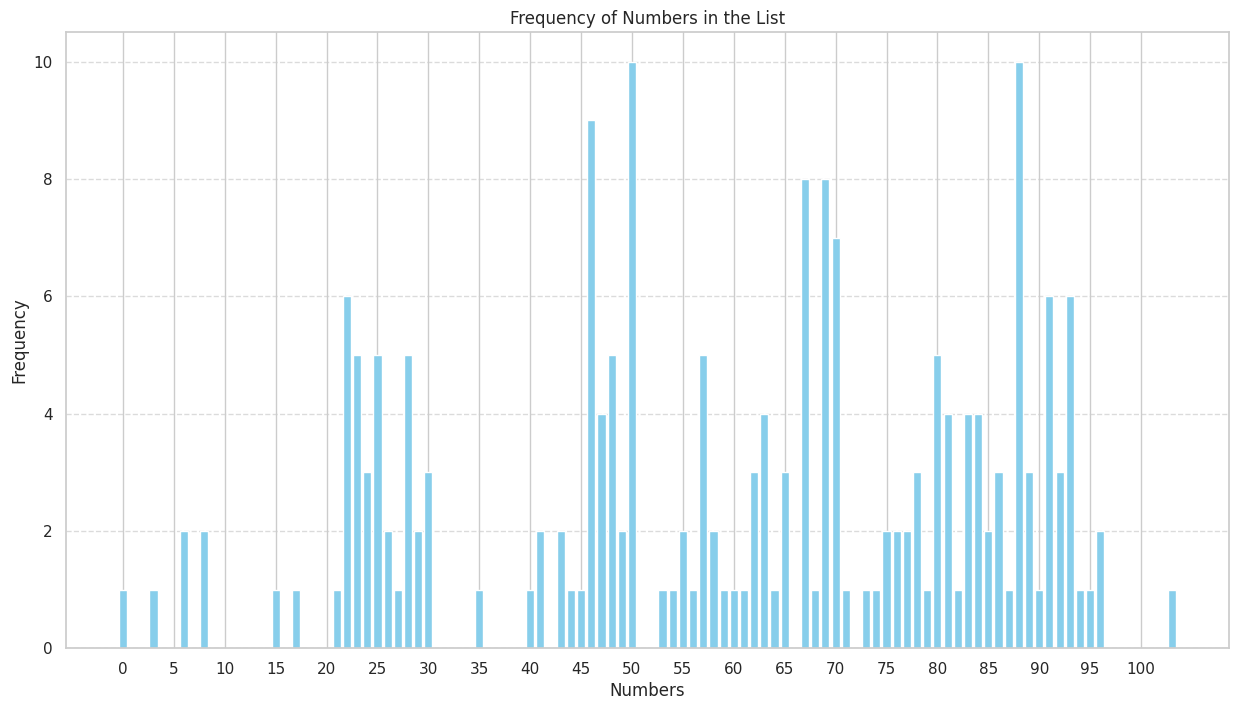

In [ ]:
combine_index = ite0+ite1+ite2+ite3+ite4+ite5+ite6+ite7+ite8+ite9
combine_index
from collections import Counter
frequency = Counter(combine_index)
frequency_sorted = sorted(frequency.items())
frequency_sorted
import matplotlib.pyplot as plt
# Extracting keys and values for plotting
numbers = [item[0] for item in frequency_sorted]
counts = [item[1] for item in frequency_sorted]

# Plotting the bar chart
plt.figure(figsize=(15, 8))
plt.bar(numbers, counts, color='skyblue')
plt.xlabel('Numbers')
plt.ylabel('Frequency')
plt.title('Frequency of Numbers in the List')
plt.xticks(range(0, max(numbers) + 1, 5))  # Setting x-ticks for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

In [ ]:
# overlap matrix
data_set = [
    ite0,
    ite1,
    ite2,
    ite3,
    ite4,
    ite5,
    ite6,
    ite7,
    ite8,
    ite9
]

overlap_matrix = [[0 for _ in range(10)] for _ in range(10)]

for i in range(10):
    for j in range(10):
        if i != j:
            overlap_matrix[i][j] = len(set(data_set[i]) & set(data_set[j]))

for row in overlap_matrix:
    print(row)


In [ ]:
results['satellite']['ResNet']['accuracies']

[0.8582857142857143,
 0.9394285714285714,
 0.9337142857142857,
 0.88,
 0.8742857142857143,
 0.8422857142857143,
 0.9577142857142857,
 0.9314285714285714,
 0.8548571428571429]

(0.9, 1.0)

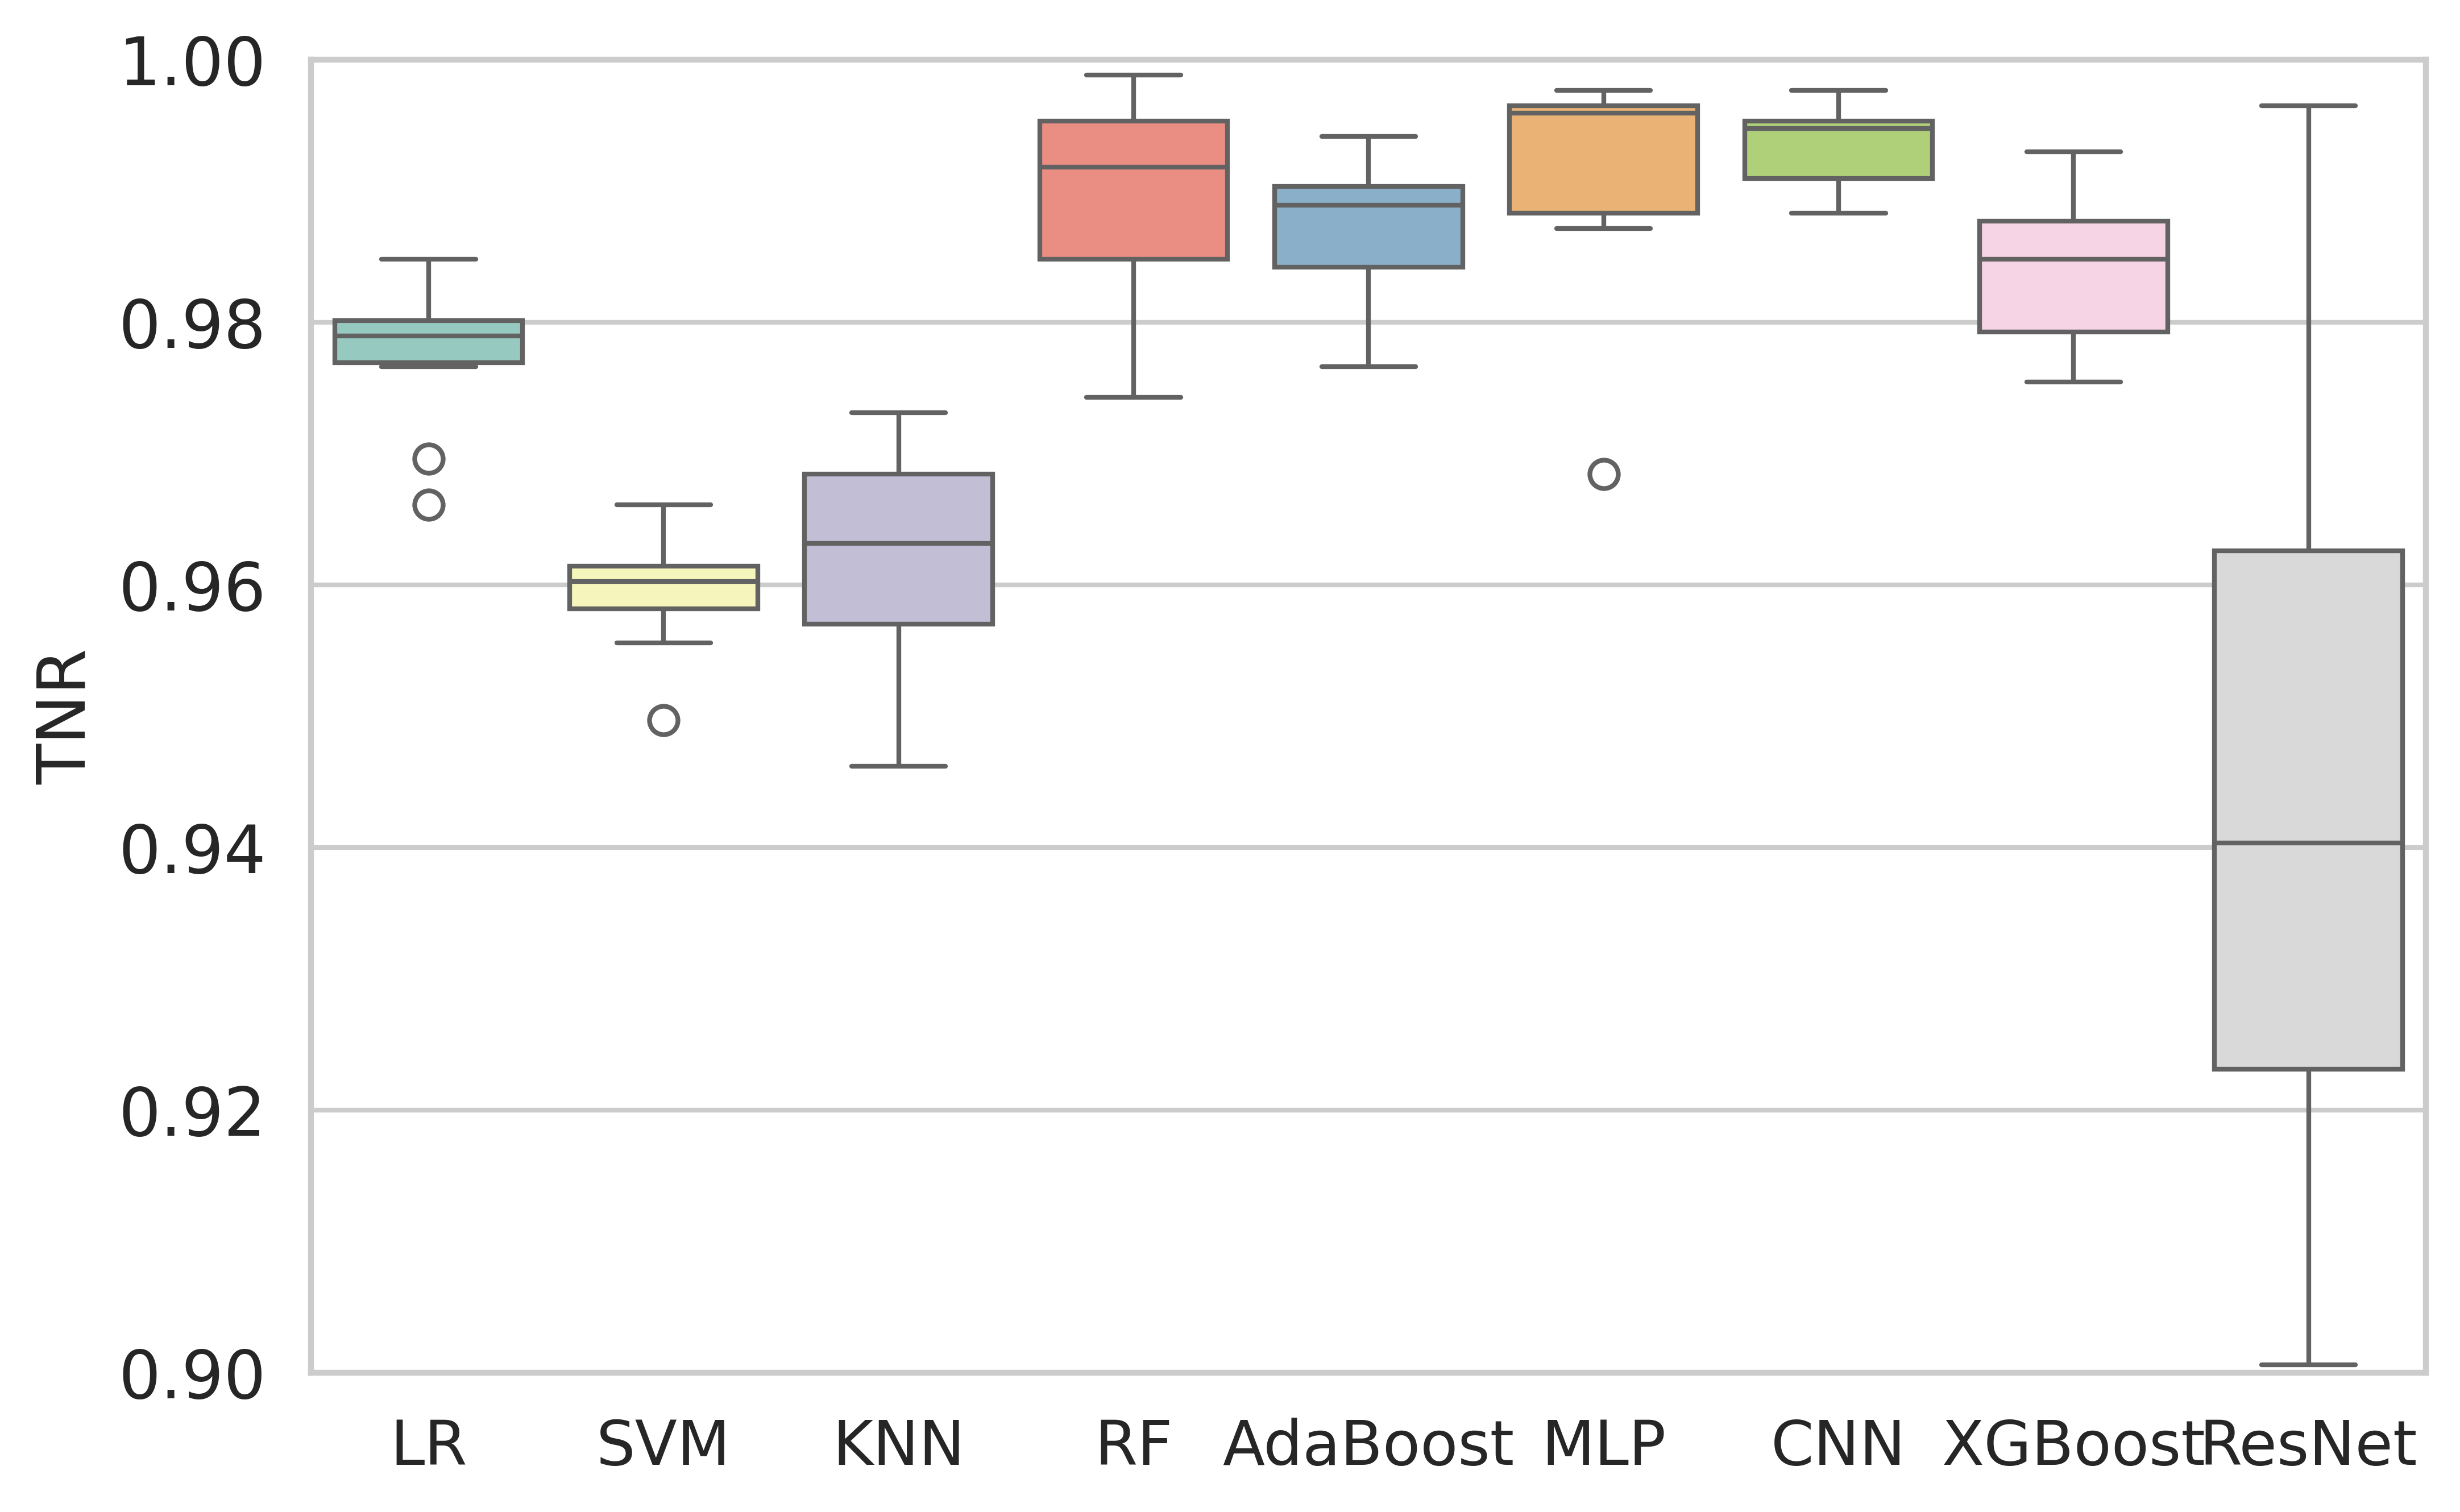

In [ ]:
## boxplot
bp1 = results['glider']['Logistic Regression']['tnrs']
bp2 = results['glider']['SVM']['tnrs']
bp3 = results['glider']['KNN']['tnrs']
bp4 = results['glider']['Random Forest']['tnrs']
bp5 = results['glider']['AdaBoost']['tnrs']
bp6 = results['glider']['MLP']['tnrs']
bp7 = results['glider']['CNN']['tnrs']
bp8 = results['glider']['XGBoost']['tnrs']
bp9 = results['glider']['ResNet']['tnrs']

sns.set(style="whitegrid")
plt.figure(figsize=(8, 5),dpi=600)
sns.boxplot([bp1,bp2,bp3,bp4,bp5,bp6,bp7,bp8,bp9], palette="Set3")

#
plt.xticks([0, 1, 2,3,4,5,6,7,8], ['LR','SVM', 'KNN','RF', 'AdaBoost', 'MLP', 'CNN','XGBoost','ResNet'])
plt.xticks(fontsize=13)
plt.yticks(fontsize=14)
plt.ylabel('TNR',fontsize = 14)
plt.xticks(rotation=0
           )
plt.ylim(0.9,1)



In [ ]:
for key, value in predictions_dict.items():
    iteration, feature_set_name, model_name = key
    pred_column_name = f"{model_name}_{feature_set_name}_pred"
    #  in all_test_sets find index to match
    matching_rows = (all_test_sets['iteration'] == iteration) & (all_test_sets.index.isin(value['indices']))
    all_test_sets.loc[matching_rows, pred_column_name] = value['predictions']

In [ ]:
## all_test_sets: drop+interpolate
## sets1: new

In [ ]:
## save to csv
csv_file_path = '/content/drive/My Drive/Colab Notebooks/all_test_sets1.csv'

all_test_sets.to_csv(csv_file_path, index=False)

In [ ]:
all_test_sets = pd.read_csv('drive/My Drive/Colab Notebooks/Classification/all_test_sets.csv')

In [ ]:
rf_sl_1 = all_test_sets[all_test_sets['Random Forest_both_pred']==1]
rf_sl_0 = all_test_sets[all_test_sets['Random Forest_both_pred']==0]
ab_sl_1 = all_test_sets[all_test_sets['AdaBoost_both_pred']==1]
ab_sl_0 = all_test_sets[all_test_sets['AdaBoost_both_pred']==0]

In [ ]:
r1 = all_test_sets[(all_test_sets['Random Forest_satellite_pred']==1)&(all_test_sets['season']==1)]
r2 = all_test_sets[(all_test_sets['Random Forest_satellite_pred']==0)&(all_test_sets['season']==1)]
a1 = all_test_sets[(all_test_sets['AdaBoost_satellite_pred']==1)&(all_test_sets['season']==1)]
a2 = all_test_sets[(all_test_sets['AdaBoost_satellite_pred']==0)&(all_test_sets['season']==1)]
r3 = all_test_sets[(all_test_sets['Random Forest_satellite_pred']==1)&(all_test_sets['season']==2)]
r4 = all_test_sets[(all_test_sets['Random Forest_satellite_pred']==0)&(all_test_sets['season']==2)]
a3 = all_test_sets[(all_test_sets['AdaBoost_satellite_pred']==1)&(all_test_sets['season']==2)]
a4 = all_test_sets[(all_test_sets['AdaBoost_satellite_pred']==0)&(all_test_sets['season']==2)]
r5 = all_test_sets[(all_test_sets['Random Forest_satellite_pred']==1)&(all_test_sets['season']==3)]
r6 = all_test_sets[(all_test_sets['Random Forest_satellite_pred']==0)&(all_test_sets['season']==3)]
a5 = all_test_sets[(all_test_sets['AdaBoost_satellite_pred']==1)&(all_test_sets['season']==3)]
a6 = all_test_sets[(all_test_sets['AdaBoost_satellite_pred']==0)&(all_test_sets['season']==3)]
r7 = all_test_sets[(all_test_sets['Random Forest_satellite_pred']==1)&(all_test_sets['season']==4)]
r8 = all_test_sets[(all_test_sets['Random Forest_satellite_pred']==0)&(all_test_sets['season']==4)]
a7 = all_test_sets[(all_test_sets['AdaBoost_satellite_pred']==1)&(all_test_sets['season']==4)]
a8 = all_test_sets[(all_test_sets['AdaBoost_satellite_pred']==0)&(all_test_sets['season']==4)]

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot([ab_sl_1['sst'],ab_sl_0['sst']], palette="Set3")
plt.xticks([0, 1],
           ['Positive Prediction', 'Negative Prediction'])
plt.xticks(fontsize = 16)

plt.title('Boxplot for Satellite variables',fontsize = 20)
plt.ylabel('SST',fontsize = 16)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.boxplot(data = [r1['sst'],r2['sst'],
             r3['sst'],r4['sst'],
             r5['sst'],r6['sst'],
             r7['sst'],r8['sst']], palette="Set3",orient='h')

plt.title('Boxplot for Satellite variables')
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7],
           ['Positive Prediction Spring', 'Negative Prediction Spring',
            'Positive Prediction Summer', 'Negative Prediction Summer',
            'Positive Prediction Fall', 'Negative Prediction Fall',
            'Positive Prediction Winter', 'Negative Prediction Winter'])
plt.xlabel('SST')
plt.xticks(rotation=0
           )

plt.show()